In [2]:
# import libraries
import numpy as np
from sklearn import preprocessing
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import pickle

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [15]:
# parameters for PFR
k_0 = 8.46 * (np.power(10,6))
C_p = 0.231
rho_L = 1000
u = 2 # volumetric flow rate  (F/A) Superficial velocity
E_by_R = 5*(np.power(10,4)) / 8.314
delH_term = -1.15*(np.power(10,4))
U = 25
Tc_s = 293
At = 0.01 # Area for heating rate equation
A = 0.002  # Area
length = 1 # total length of reactor
N = 10     # number of points to discretize the reactor

t_final = 0.1
t_step = 0.01

num_step = 10
num_dims = 4

# parameters for NN
seed = 0
plot = True
rng = np.random.RandomState(seed)
innerepochs = 500 # number of epochs of each inner SGD
ntrain = 128 # size of training minibatches (K)
threshold = 10

In [16]:
# convert numpy array to tensor
def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

In [17]:
# normal training loop
def train_data_driven(model, n_epochs):
    optimizer = tf.keras.optimizers.Adam()

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss = tf.reduce_mean((NN_output - y)**2)

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # if epoch % 100 == 0:
        #     print("Training loss: ", loss)

    return model

In [18]:
# physics-informed training loop
def train(model, n_epochs, x_collocation):
    optimizer = tf.keras.optimizers.Adam()

    mean_X = to_tensor(scaler_X_pfr.mean_)
    std_X = to_tensor(np.sqrt(scaler_X_pfr.var_))
    mean_y = to_tensor(scaler_y_pfr.mean_)
    std_y = to_tensor(np.sqrt(scaler_y_pfr.var_))

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss1 = K.mean((NN_output[:, :, :] - y[:, :, :])**2)

                NN_output = model(x_collocation)

                CA_NN_input = x_collocation[:, :, 1] * std_X[1] + mean_X[1]
                T_NN_input = x_collocation[:, :, 0] * std_X[0] + mean_X[0]
                Tc = x_collocation[:, :, 2] * std_X[2] + mean_X[2] + Tc_s_new_pfr

                NN_output = NN_output * std_y + mean_y

                dCA_first = (NN_output[:, 1:2, 1] - NN_output[:, 0:1, 1]) / (t_step)
                dT_first = (NN_output[:, 1:2, 0] - NN_output[:, 0:1, 0]) / (t_step)

                dCA_center = (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2*t_step)
                dT_center = (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2*t_step)

                dCA_last = (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step)
                dT_last = (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step)

                dCA = K.concatenate((dCA_first, dCA_center, dCA_last), 1)
                dT = K.concatenate((dT_first, dT_center, dT_last), 1)

                z = np.linspace(0, length, N)

                lossCA = dCA + u_new_pfr * (NN_output[:, :, 1].numpy() - CA_NN_input[:, :]) / (np.diff(z)[0]) + k_0 * K.exp(-E_by_R / NN_output[:, :, 0]) * NN_output[:, :, 1]
                lossCA = K.mean(lossCA**2)

                lossT = dT + u_new_pfr * (NN_output[:, :, 0].numpy() - T_NN_input[:, :]) / (np.diff(z)[0]) - (-delH_term / (rho_L * C_p)) * k_0 * K.exp(-E_by_R / NN_output[:, :, 0]) * NN_output[:, :, 1] - (U_new_pfr / (rho_L * C_p * A_new_pfr)) * At_new_pfr * (Tc - NN_output[:, :, 0])
                lossT = K.mean(lossT**2)

                # print(lossCA)
                # print(lossT)

                loss = 1e3 * loss1 + 1e-2 * lossCA + 1e-5 * lossT

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # if epoch % 100 == 0:
        #     print("Training loss: ", loss)

    return model

In [19]:
# define neural network model
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, return_sequences=True)
        self.layer_2 = SimpleRNN(64, return_sequences=True)
        self.layer_3 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [20]:
# load the unseen datasets
with open('x_pfr_1.pkl', 'rb') as f:
    x_all = pickle.load(f)

with open('y_pfr_1.pkl', 'rb') as f:
    y_all = pickle.load(f)

with open('x_pfr_scaler_1.pkl', 'rb') as f:
    scaler_X_pfr = pickle.load(f)

with open('y_pfr_scaler_1.pkl', 'rb') as f:
    scaler_y_pfr = pickle.load(f)

with open('Tc_s_new_pfr_1.pkl', 'rb') as f:
    Tc_s_new_pfr = pickle.load(f)

with open('u_new_pfr_1.pkl', 'rb') as f:
    u_new_pfr = pickle.load(f)

with open('U_new_pfr_1.pkl', 'rb') as f:
    U_new_pfr = pickle.load(f)

with open('A_new_pfr_1.pkl', 'rb') as f:
    A_new_pfr = pickle.load(f)

with open('At_new_pfr_1.pkl', 'rb') as f:
    At_new_pfr = pickle.load(f)

In [21]:
# check mean and variance of pfr generated
print(scaler_X_pfr.mean_)
print(scaler_X_pfr.var_)
print(scaler_y_pfr.mean_)
print(scaler_y_pfr.var_)

[400.     1.75 200.   200.  ]
[3.50427350e+03 5.47542735e-01 5.55555556e+03 5.55555556e+03]
[338.04824355   0.6746027 ]
[9.60505358e+02 1.77044062e-01]


In [22]:
# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

In [23]:
# 10-shot learning on unseen task wrt 500 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):

    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

No. of collocation points:  1
Testing loss of PI-reptile:  0.016992954537272453
Testing loss of PI:  0.2694915235042572
No. of collocation points:  2
Testing loss of PI-reptile:  0.01525635365396738
Testing loss of PI:  0.3332282602787018
No. of collocation points:  3
Testing loss of PI-reptile:  0.0163691658526659
Testing loss of PI:  0.3560279309749603
No. of collocation points:  4
Testing loss of PI-reptile:  0.017044387757778168
Testing loss of PI:  0.5326040983200073
No. of collocation points:  5
Testing loss of PI-reptile:  0.01771162822842598
Testing loss of PI:  0.18186508119106293
No. of collocation points:  6
Testing loss of PI-reptile:  0.018178965896368027
Testing loss of PI:  0.8177774548530579
No. of collocation points:  7
Testing loss of PI-reptile:  0.017214711755514145
Testing loss of PI:  0.4932907223701477
No. of collocation points:  8
Testing loss of PI-reptile:  0.016436420381069183
Testing loss of PI:  0.567134439945221
No. of collocation points:  9
Testing loss o

Testing loss of PI:  0.07244503498077393
No. of collocation points:  69
Testing loss of PI-reptile:  0.004719946067780256
Testing loss of PI:  0.0822671428322792
No. of collocation points:  70
Testing loss of PI-reptile:  0.004759030416607857
Testing loss of PI:  0.08296873420476913
No. of collocation points:  71
Testing loss of PI-reptile:  0.004952480085194111
Testing loss of PI:  0.08957646042108536
No. of collocation points:  72
Testing loss of PI-reptile:  0.004956099204719067
Testing loss of PI:  0.0897563025355339
No. of collocation points:  73
Testing loss of PI-reptile:  0.004924063105136156
Testing loss of PI:  0.12283600121736526
No. of collocation points:  74
Testing loss of PI-reptile:  0.004706007894128561
Testing loss of PI:  0.10100692510604858
No. of collocation points:  75
Testing loss of PI-reptile:  0.004846517462283373
Testing loss of PI:  0.10316390544176102
No. of collocation points:  76
Testing loss of PI-reptile:  0.00471284007653594
Testing loss of PI:  0.1215

In [24]:
# save results
np.savetxt("test_loss_PI_pfr_1_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_pfr_1_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

In [25]:
# rerun for 2nd pfr
# load the unseen datasets
with open('x_pfr_2.pkl', 'rb') as f:
    x_all = pickle.load(f)

with open('y_pfr_2.pkl', 'rb') as f:
    y_all = pickle.load(f)

with open('x_pfr_scaler_2.pkl', 'rb') as f:
    scaler_X_pfr = pickle.load(f)

with open('y_pfr_scaler_2.pkl', 'rb') as f:
    scaler_y_pfr = pickle.load(f)

with open('Tc_s_new_pfr_2.pkl', 'rb') as f:
    Tc_s_new_pfr = pickle.load(f)

with open('u_new_pfr_2.pkl', 'rb') as f:
    u_new_pfr = pickle.load(f)

with open('U_new_pfr_2.pkl', 'rb') as f:
    U_new_pfr = pickle.load(f)

with open('A_new_pfr_2.pkl', 'rb') as f:
    A_new_pfr = pickle.load(f)

with open('At_new_pfr_2.pkl', 'rb') as f:
    At_new_pfr = pickle.load(f)

# check mean and variance of pfr generated
print(scaler_X_pfr.mean_)
print(scaler_X_pfr.var_)
print(scaler_y_pfr.mean_)
print(scaler_y_pfr.var_)

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# 10-shot learning on unseen task wrt 500 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):

    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

# save results
np.savetxt("test_loss_PI_pfr_2_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_pfr_2_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

[400.     1.75 200.   200.  ]
[3.50427350e+03 5.47542735e-01 5.55555556e+03 5.55555556e+03]
[340.77795797   0.78897042]
[1.47808478e+03 2.26822250e-01]
No. of collocation points:  1
Testing loss of PI-reptile:  0.01696193590760231
Testing loss of PI:  0.2996022701263428
No. of collocation points:  2
Testing loss of PI-reptile:  0.017462125048041344
Testing loss of PI:  0.3528832793235779
No. of collocation points:  3
Testing loss of PI-reptile:  0.016421249136328697
Testing loss of PI:  0.31747791171073914
No. of collocation points:  4
Testing loss of PI-reptile:  0.016030920669436455
Testing loss of PI:  0.6248992681503296
No. of collocation points:  5
Testing loss of PI-reptile:  0.01547072734683752
Testing loss of PI:  0.3145945072174072
No. of collocation points:  6
Testing loss of PI-reptile:  0.016906367614865303
Testing loss of PI:  0.44169414043426514
No. of collocation points:  7
Testing loss of PI-reptile:  0.016275538131594658
Testing loss of PI:  0.17773963510990143
No. of 

Testing loss of PI:  0.09971707314252853
No. of collocation points:  68
Testing loss of PI-reptile:  0.006197328679263592
Testing loss of PI:  0.08129288256168365
No. of collocation points:  69
Testing loss of PI-reptile:  0.0064221774227917194
Testing loss of PI:  0.05533472076058388
No. of collocation points:  70
Testing loss of PI-reptile:  0.007831008173525333
Testing loss of PI:  0.055900830775499344
No. of collocation points:  71
Testing loss of PI-reptile:  0.0107988016679883
Testing loss of PI:  0.07538928091526031
No. of collocation points:  72
Testing loss of PI-reptile:  0.01035796757787466
Testing loss of PI:  0.08837106078863144
No. of collocation points:  73
Testing loss of PI-reptile:  0.006223171483725309
Testing loss of PI:  0.0985884889960289
No. of collocation points:  74
Testing loss of PI-reptile:  0.004940391052514315
Testing loss of PI:  0.09185614436864853
No. of collocation points:  75
Testing loss of PI-reptile:  0.005455155856907368
Testing loss of PI:  0.105

In [22]:
# rerun for 3rd pfr
# load the unseen datasets
with open('x_pfr_3.pkl', 'rb') as f:
    x_all = pickle.load(f)

with open('y_pfr_3.pkl', 'rb') as f:
    y_all = pickle.load(f)

with open('x_pfr_scaler_3.pkl', 'rb') as f:
    scaler_X_pfr = pickle.load(f)

with open('y_pfr_scaler_3.pkl', 'rb') as f:
    scaler_y_pfr = pickle.load(f)

with open('Tc_s_new_pfr_3.pkl', 'rb') as f:
    Tc_s_new_pfr = pickle.load(f)

with open('u_new_pfr_3.pkl', 'rb') as f:
    u_new_pfr = pickle.load(f)

with open('U_new_pfr_3.pkl', 'rb') as f:
    U_new_pfr = pickle.load(f)

with open('A_new_pfr_3.pkl', 'rb') as f:
    A_new_pfr = pickle.load(f)

with open('At_new_pfr_3.pkl', 'rb') as f:
    At_new_pfr = pickle.load(f)

# check mean and variance of pfr generated
print(scaler_X_pfr.mean_)
print(scaler_X_pfr.var_)
print(scaler_y_pfr.mean_)
print(scaler_y_pfr.var_)

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# 10-shot learning on unseen task wrt 500 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):

    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

# save results
np.savetxt("test_loss_PI_pfr_3_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_pfr_3_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

[400.     1.75 200.   200.  ]
[3.50427350e+03 5.47542735e-01 5.55555556e+03 5.55555556e+03]
[393.13489152   0.83762194]
[1.79019672e+03 2.43803816e-01]
No. of collocation points:  1
Testing loss of PI-reptile:  0.010933004319667816
Testing loss of PI:  0.36147192120552063
No. of collocation points:  2
Testing loss of PI-reptile:  0.01130895595997572
Testing loss of PI:  0.2764908969402313
No. of collocation points:  3
Testing loss of PI-reptile:  0.012353640981018543
Testing loss of PI:  0.29995089769363403
No. of collocation points:  4
Testing loss of PI-reptile:  0.01878502406179905
Testing loss of PI:  0.16420809924602509
No. of collocation points:  5
Testing loss of PI-reptile:  0.013505976647138596
Testing loss of PI:  0.21633633971214294
No. of collocation points:  6
Testing loss of PI-reptile:  0.011271554045379162
Testing loss of PI:  0.25143134593963623
No. of collocation points:  7
Testing loss of PI-reptile:  0.015246938914060593
Testing loss of PI:  0.2692485451698303
No. o

Testing loss of PI:  0.13168177008628845
No. of collocation points:  68
Testing loss of PI-reptile:  0.0093787657096982
Testing loss of PI:  0.13681741058826447
No. of collocation points:  69
Testing loss of PI-reptile:  0.010830466635525227
Testing loss of PI:  0.14430715143680573
No. of collocation points:  70
Testing loss of PI-reptile:  0.011649740859866142
Testing loss of PI:  0.12136390805244446
No. of collocation points:  71
Testing loss of PI-reptile:  0.011289707385003567
Testing loss of PI:  0.13873261213302612
No. of collocation points:  72
Testing loss of PI-reptile:  0.010154234245419502
Testing loss of PI:  0.127221941947937
No. of collocation points:  73
Testing loss of PI-reptile:  0.010636822320520878
Testing loss of PI:  0.1402212232351303
No. of collocation points:  74
Testing loss of PI-reptile:  0.01584966853260994
Testing loss of PI:  0.1132986843585968
No. of collocation points:  75
Testing loss of PI-reptile:  0.006733570713549852
Testing loss of PI:  0.13009454

In [23]:
# rerun for 4th pfr
# load the unseen datasets
with open('x_pfr_4.pkl', 'rb') as f:
    x_all = pickle.load(f)

with open('y_pfr_4.pkl', 'rb') as f:
    y_all = pickle.load(f)

with open('x_pfr_scaler_4.pkl', 'rb') as f:
    scaler_X_pfr = pickle.load(f)

with open('y_pfr_scaler_4.pkl', 'rb') as f:
    scaler_y_pfr = pickle.load(f)

with open('Tc_s_new_pfr_4.pkl', 'rb') as f:
    Tc_s_new_pfr = pickle.load(f)

with open('u_new_pfr_4.pkl', 'rb') as f:
    u_new_pfr = pickle.load(f)

with open('U_new_pfr_4.pkl', 'rb') as f:
    U_new_pfr = pickle.load(f)

with open('A_new_pfr_4.pkl', 'rb') as f:
    A_new_pfr = pickle.load(f)

with open('At_new_pfr_4.pkl', 'rb') as f:
    At_new_pfr = pickle.load(f)

# check mean and variance of pfr generated
print(scaler_X_pfr.mean_)
print(scaler_X_pfr.var_)
print(scaler_y_pfr.mean_)
print(scaler_y_pfr.var_)

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# 10-shot learning on unseen task wrt 500 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):

    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

# save results
np.savetxt("test_loss_PI_pfr_4_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_pfr_4_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

[400.     1.75 200.   200.  ]
[3.50427350e+03 5.47542735e-01 5.55555556e+03 5.55555556e+03]
[384.76485657   1.02652262]
[2.83533130e+03 3.41290495e-01]
No. of collocation points:  1
Testing loss of PI-reptile:  0.015977466478943825
Testing loss of PI:  0.26111602783203125
No. of collocation points:  2
Testing loss of PI-reptile:  0.02159259468317032
Testing loss of PI:  0.2935633063316345
No. of collocation points:  3
Testing loss of PI-reptile:  0.01957630179822445
Testing loss of PI:  0.32633575797080994
No. of collocation points:  4
Testing loss of PI-reptile:  0.017193539068102837
Testing loss of PI:  0.2508319914340973
No. of collocation points:  5
Testing loss of PI-reptile:  0.016019606962800026
Testing loss of PI:  0.3554918169975281
No. of collocation points:  6
Testing loss of PI-reptile:  0.016159700229763985
Testing loss of PI:  0.2992202639579773
No. of collocation points:  7
Testing loss of PI-reptile:  0.015256579965353012
Testing loss of PI:  0.5343338847160339
No. of c

Testing loss of PI:  0.1648307740688324
No. of collocation points:  68
Testing loss of PI-reptile:  0.016093414276838303
Testing loss of PI:  0.1559368222951889
No. of collocation points:  69
Testing loss of PI-reptile:  0.011713365092873573
Testing loss of PI:  0.13954290747642517
No. of collocation points:  70
Testing loss of PI-reptile:  0.011021822690963745
Testing loss of PI:  0.21501107513904572
No. of collocation points:  71
Testing loss of PI-reptile:  0.01304153073579073
Testing loss of PI:  0.14445894956588745
No. of collocation points:  72
Testing loss of PI-reptile:  0.013153979554772377
Testing loss of PI:  0.13063974678516388
No. of collocation points:  73
Testing loss of PI-reptile:  0.01205768994987011
Testing loss of PI:  0.15242122113704681
No. of collocation points:  74
Testing loss of PI-reptile:  0.010496092028915882
Testing loss of PI:  0.10281319916248322
No. of collocation points:  75
Testing loss of PI-reptile:  0.01361805573105812
Testing loss of PI:  0.166497

In [24]:
# rerun for 5th pfr
# load the unseen datasets
with open('x_pfr_5.pkl', 'rb') as f:
    x_all = pickle.load(f)

with open('y_pfr_5.pkl', 'rb') as f:
    y_all = pickle.load(f)

with open('x_pfr_scaler_5.pkl', 'rb') as f:
    scaler_X_pfr = pickle.load(f)

with open('y_pfr_scaler_5.pkl', 'rb') as f:
    scaler_y_pfr = pickle.load(f)

with open('Tc_s_new_pfr_5.pkl', 'rb') as f:
    Tc_s_new_pfr = pickle.load(f)

with open('u_new_pfr_5.pkl', 'rb') as f:
    u_new_pfr = pickle.load(f)

with open('U_new_pfr_5.pkl', 'rb') as f:
    U_new_pfr = pickle.load(f)

with open('A_new_pfr_5.pkl', 'rb') as f:
    A_new_pfr = pickle.load(f)

with open('At_new_pfr_5.pkl', 'rb') as f:
    At_new_pfr = pickle.load(f)

# check mean and variance of pfr generated
print(scaler_X_pfr.mean_)
print(scaler_X_pfr.var_)
print(scaler_y_pfr.mean_)
print(scaler_y_pfr.var_)

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# 10-shot learning on unseen task wrt 500 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):

    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

# save results
np.savetxt("test_loss_PI_pfr_5_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_pfr_5_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

[400.     1.75 200.   200.  ]
[3.50427350e+03 5.47542735e-01 5.55555556e+03 5.55555556e+03]
[386.75100597   0.40866655]
[2.90466544e+02 7.01433098e-02]
No. of collocation points:  1
Testing loss of PI-reptile:  0.010706395842134953
Testing loss of PI:  0.331699401140213
No. of collocation points:  2
Testing loss of PI-reptile:  0.010433660820126534
Testing loss of PI:  0.20215953886508942
No. of collocation points:  3
Testing loss of PI-reptile:  0.010611051693558693
Testing loss of PI:  0.2628828287124634
No. of collocation points:  4
Testing loss of PI-reptile:  0.010281509719789028
Testing loss of PI:  0.21802404522895813
No. of collocation points:  5
Testing loss of PI-reptile:  0.010317192412912846
Testing loss of PI:  0.24304746091365814
No. of collocation points:  6
Testing loss of PI-reptile:  0.010195320472121239
Testing loss of PI:  0.27839192748069763
No. of collocation points:  7
Testing loss of PI-reptile:  0.010099751874804497
Testing loss of PI:  0.1914263516664505
No. o

Testing loss of PI:  0.2014341503381729
No. of collocation points:  68
Testing loss of PI-reptile:  0.006474534049630165
Testing loss of PI:  0.2216358482837677
No. of collocation points:  69
Testing loss of PI-reptile:  0.006378636695444584
Testing loss of PI:  0.1944846659898758
No. of collocation points:  70
Testing loss of PI-reptile:  0.006496570073068142
Testing loss of PI:  0.17217829823493958
No. of collocation points:  71
Testing loss of PI-reptile:  0.006515359040349722
Testing loss of PI:  0.12796251475811005
No. of collocation points:  72
Testing loss of PI-reptile:  0.006364182103425264
Testing loss of PI:  0.27777838706970215
No. of collocation points:  73
Testing loss of PI-reptile:  0.006660702638328075
Testing loss of PI:  0.22774870693683624
No. of collocation points:  74
Testing loss of PI-reptile:  0.006278901360929012
Testing loss of PI:  0.2539825141429901
No. of collocation points:  75
Testing loss of PI-reptile:  0.0054342118091881275
Testing loss of PI:  0.1266

In [53]:
# get mean and std
test_loss_PI_pfr_1 = np.loadtxt("test_loss_PI_pfr_1_time.txt")
test_loss_PI_pfr_2 = np.loadtxt("test_loss_PI_pfr_2_time.txt")
test_loss_PI_pfr_3 = np.loadtxt("test_loss_PI_pfr_3_time.txt")
test_loss_PI_pfr_4 = np.loadtxt("test_loss_PI_pfr_4_time.txt")
test_loss_PI_pfr_5 = np.loadtxt("test_loss_PI_pfr_5_time.txt")

test_loss_PI_pfr_mean = np.mean((test_loss_PI_pfr_1, test_loss_PI_pfr_2, test_loss_PI_pfr_3, test_loss_PI_pfr_4, test_loss_PI_pfr_5), axis=0)
test_loss_PI_pfr_std = np.std((test_loss_PI_pfr_1, test_loss_PI_pfr_2, test_loss_PI_pfr_3, test_loss_PI_pfr_4, test_loss_PI_pfr_5), axis=0)

test_loss_PI_reptile_pfr_1 = np.loadtxt("test_loss_PI_reptile_pfr_1_time.txt")
test_loss_PI_reptile_pfr_2 = np.loadtxt("test_loss_PI_reptile_pfr_2_time.txt")
test_loss_PI_reptile_pfr_3 = np.loadtxt("test_loss_PI_reptile_pfr_3_time.txt")
test_loss_PI_reptile_pfr_4 = np.loadtxt("test_loss_PI_reptile_pfr_4_time.txt")
test_loss_PI_reptile_pfr_5 = np.loadtxt("test_loss_PI_reptile_pfr_5_time.txt")

test_loss_PI_reptile_pfr_mean = np.mean((test_loss_PI_reptile_pfr_1, test_loss_PI_reptile_pfr_2, test_loss_PI_reptile_pfr_3, test_loss_PI_reptile_pfr_4, test_loss_PI_reptile_pfr_5), axis=0)
test_loss_PI_reptile_pfr_std = np.std((test_loss_PI_reptile_pfr_1, test_loss_PI_reptile_pfr_2, test_loss_PI_reptile_pfr_3, test_loss_PI_reptile_pfr_4, test_loss_PI_reptile_pfr_5), axis=0)

In [54]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

meta NOT subset; don't know how to subset; dropped


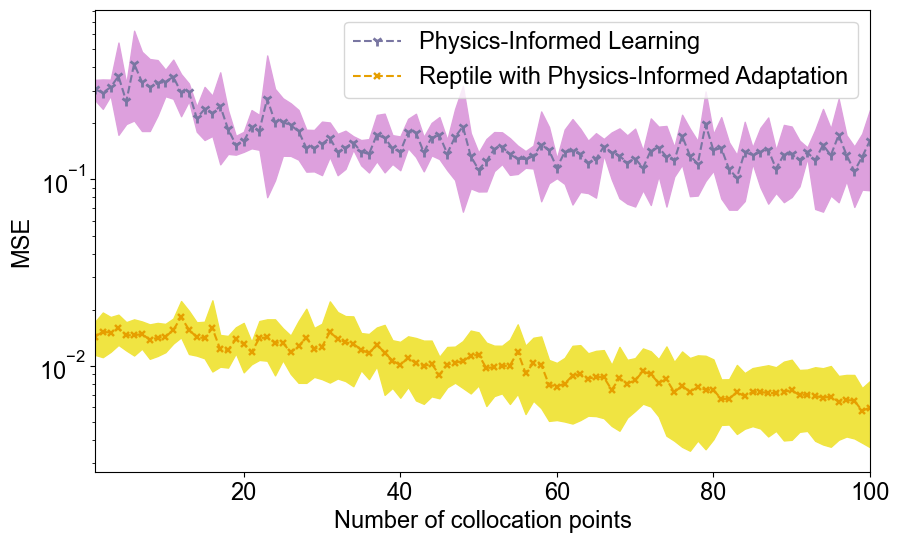

In [55]:
# Testing
test_loss_reference = [0.002]

size = 100
x = np.arange(1,size+1,1)

plt.figure(figsize=(10,6))
plt.rc('font', size=17)

plt.plot(x, test_loss_PI_pfr_mean[:size], '--', color='#7976A2', marker='1', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Physics-Informed Learning')
plt.fill_between(x, test_loss_PI_pfr_mean[:size] - test_loss_PI_pfr_std[:size], test_loss_PI_pfr_mean[:size] + test_loss_PI_pfr_std[:size], edgecolor="plum", facecolor="plum")

plt.plot(x, test_loss_PI_reptile_pfr_mean[:size], '--', color='#E69F00', marker='x', linewidth=1.5, markersize=5, markeredgewidth=1.75, label='Reptile with Physics-Informed Adaptation')
plt.fill_between(x, test_loss_PI_reptile_pfr_mean[:size] - test_loss_PI_reptile_pfr_std[:size], test_loss_PI_reptile_pfr_mean[:size] + test_loss_PI_reptile_pfr_std[:size], edgecolor="#F0E442", facecolor="#F0E442")

# plt.plot(x, test_loss_reference*(size), color='#E47159', linewidth=1.5, label='Reference MSE')

plt.legend()
plt.xlabel("Number of collocation points")
plt.ylabel("MSE")
plt.margins(x=0)
plt.yscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('pfr_time.pdf')
plt.show()